#### Model v2 -- to run code below I had to switch into a different virtual environment and install just these packages

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import numpy as np
from skimage.filters import gabor_kernel
import copy
from PIL import Image
import matplotlib.pyplot as plt
import copy

import modeling

In [11]:
transform_cifar = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 64

cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)
cifar_train_loader = DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True)
cifar_test_loader = DataLoader(cifar_testset, batch_size=batch_size, shuffle=False)

gabor_trainset = modeling.GaborDataset(num_images=5000, img_size=32, orientations=10, frequencies=(0.08,))
gabor_testset = modeling.GaborDataset(num_images=5000, img_size=32, orientations=10, frequencies=(0.08,))
gabor_train_loader = DataLoader(gabor_trainset, batch_size=batch_size, shuffle=True)
gabor_test_loader = DataLoader(gabor_testset, batch_size=batch_size, shuffle=False)

combined_trainset = ConcatDataset([cifar_trainset, gabor_trainset])
combined_loader = DataLoader(combined_trainset, batch_size=batch_size, shuffle=True)

In [12]:
model = modeling.ConvNet(in_channels=1, height=32, width=32)
model, losses = modeling.train_model(model, combined_loader, num_epochs=50)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #4:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #5:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #6:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #7:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #8:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #9:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #10:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #11:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #12:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #13:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #14:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #15:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #16:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #17:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #18:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #19:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #20:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #21:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #22:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #23:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #24:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #25:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #26:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #27:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #28:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #29:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #30:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #31:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #32:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #33:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #34:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #35:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #36:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #37:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #38:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #39:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #40:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #41:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #42:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #43:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #44:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #45:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #46:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #47:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #48:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #49:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #50:   0%|          | 0/860 [00:00<?, ?it/s]

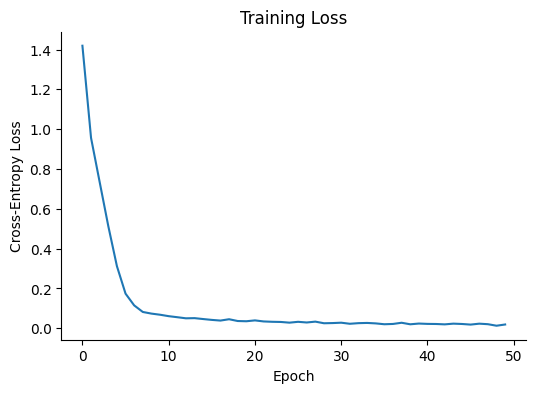

In [13]:
fig, axs = modeling.plot_losses(losses)

In [21]:
from tqdm.notebook import tqdm, trange

In [23]:
#### stability plots ####
results = {
    'idx': [],
    'gabor_acc': [],
    'cifar_acc': [],
}

noise_results = {
    'idx': [],
    'noise_level': [],
    'noisy1_gabor_acc': [],
    'noisy1_cifar_acc': [],
    'noisy2_gabor_acc': [],
    'noisy2_cifar_acc': [],
    'noisy3_gabor_acc': [],
    'noisy3_cifar_acc': []
}
noise_levels = np.arange(0, 1.05, 0.05)

for i in range(10):
    model = modeling.ConvNet(in_channels=1, height=32, width=32)
    model, losses = modeling.train_model(model, combined_loader, num_epochs=5)
    
    gabor_acc = modeling.evaluate_gabor_accuracy(model, gabor_test_loader)
    cifar_acc = modeling.evaluate_cifar_accuracy(model, cifar_test_loader)

    results['idx'].append(i)
    results['gabor_acc'].append(gabor_acc)
    results['cifar_acc'].append(cifar_acc)

    for noise in noise_levels:
        noisy_model = copy.deepcopy(model)

        noisy_first_model = modeling.add_noise_to_first_layer(noisy_model, noise_level=noise)
        noisy1_gabor_acc = modeling.evaluate_gabor_accuracy(noisy_model, gabor_test_loader)
        noisy1_cifar_acc = modeling.evaluate_cifar_accuracy(noisy_model, cifar_test_loader)

        noisy_model = copy.deepcopy(model)
        noisy_middle_model = modeling.add_noise_to_middle_layer(noisy_model, noise_level=noise)
        noisy2_gabor_acc = modeling.evaluate_gabor_accuracy(noisy_model, gabor_test_loader)
        noisy2_cifar_acc = modeling.evaluate_cifar_accuracy(noisy_model, cifar_test_loader)

        noisy_last_model = modeling.add_noise_to_last_layer(noisy_model, noise_level=noise)
        noisy3_gabor_acc = modeling.evaluate_gabor_accuracy(noisy_model, gabor_test_loader)
        noisy3_cifar_acc = modeling.evaluate_cifar_accuracy(noisy_model, cifar_test_loader)

        noise_results['idx'].append(i)
        noise_results['noise_level'].append(noise)
        noise_results['noisy1_gabor_acc'].append(noisy1_gabor_acc)
        noise_results['noisy1_cifar_acc'].append(noisy1_cifar_acc)
        noise_results['noisy2_gabor_acc'].append(noisy2_gabor_acc)
        noise_results['noisy2_cifar_acc'].append(noisy2_cifar_acc)
        noise_results['noisy3_gabor_acc'].append(noisy3_gabor_acc)
        noise_results['noisy3_cifar_acc'].append(noisy3_cifar_acc)
    
    print(f'Iteration {i+1}/10 complete.')

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #4:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #5:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #6:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #7:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #8:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #9:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #10:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #11:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #12:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #13:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #14:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #15:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #16:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #17:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #18:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #19:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #20:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #21:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #22:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #23:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #24:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #25:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #26:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #27:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #28:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #29:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #30:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #31:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #32:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #33:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #34:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #35:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #36:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #37:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #38:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #39:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #40:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #41:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #42:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #43:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #44:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #45:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #46:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #47:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #48:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #49:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #50:   0%|          | 0/860 [00:00<?, ?it/s]

Iteration 1/10 complete.


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #4:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #5:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #6:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #7:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #8:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #9:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #10:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #11:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #12:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #13:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #14:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #15:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #16:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #17:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #18:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #19:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #20:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #21:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #22:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #23:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #24:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #25:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #26:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #27:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #28:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #29:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #30:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #31:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #32:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #33:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #34:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #35:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #36:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #37:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #38:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #39:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #40:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #41:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #42:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #43:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #44:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #45:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #46:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #47:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #48:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #49:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #50:   0%|          | 0/860 [00:00<?, ?it/s]

Iteration 2/10 complete.


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #4:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #5:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #6:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #7:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #8:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #9:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #10:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #11:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #12:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #13:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #14:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #15:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #16:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #17:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #18:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #19:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #20:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #21:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #22:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #23:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #24:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #25:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #26:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #27:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #28:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #29:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #30:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #31:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #32:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #33:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #34:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #35:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #36:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #37:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #38:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #39:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #40:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #41:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #42:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #43:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #44:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #45:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #46:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #47:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #48:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #49:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #50:   0%|          | 0/860 [00:00<?, ?it/s]

Iteration 3/10 complete.


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #4:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #5:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #6:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #7:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #8:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #9:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #10:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #11:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #12:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #13:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #14:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #15:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #16:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #17:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #18:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #19:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #20:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #21:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #22:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #23:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #24:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #25:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #26:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #27:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #28:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #29:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #30:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #31:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #32:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #33:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #34:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #35:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #36:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #37:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #38:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #39:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #40:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #41:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #42:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #43:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #44:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #45:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #46:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #47:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #48:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #49:   0%|          | 0/860 [00:00<?, ?it/s]

Batches in epoch #50:   0%|          | 0/860 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [26]:
import pandas as pd
noise_results_df = pd.DataFrame(noise_results)
noise_results_df

,idx,noise_level,noisy1_gabor_acc,noisy1_cifar_acc,noisy2_gabor_acc,noisy2_cifar_acc,noisy3_gabor_acc,noisy3_cifar_acc
0,0,0.00,100.00,63.39,100.0,63.39,100.00,63.39
1,0,0.05,100.00,63.37,100.0,63.41,100.00,63.43
2,0,0.10,100.00,60.45,100.0,63.01,100.00,60.04
3,0,0.15,100.00,58.97,100.0,61.66,100.00,59.51
4,0,0.20,100.00,42.79,100.0,60.84,100.00,56.39
...,...,...,...,...,...,...,...,...
76,3,0.65,80.14,23.40,60.1,22.88,100.00,21.38
77,3,0.70,100.00,22.28,100.0,25.26,69.30,16.22
78,3,0.75,79.60,24.99,9.9,16.66,29.36,18.76
79,3,0.80,90.36,17.62,79.6,22.73,29.58,16.35


Text(0.5, 1.0, 'Model Performance vs. Noise Level')

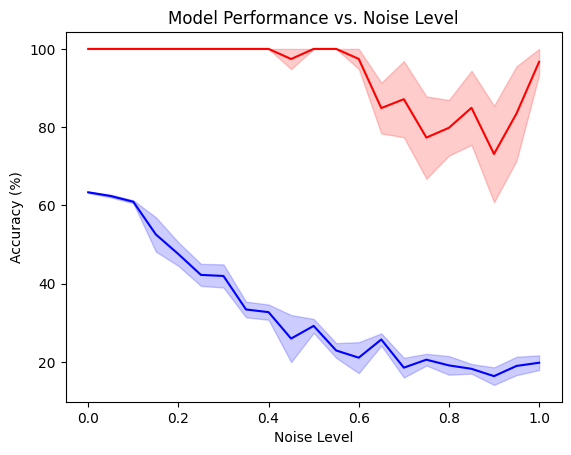

In [54]:
import seaborn as sns

sns.lineplot(
    data=noise_results_df, 
    x='noise_level', 
    y='noisy1_gabor_acc', 
    err_style='band',
    errorbar='se',
    markers='o',
    color='red',
    )

sns.lineplot(
    data=noise_results_df, 
    x='noise_level', 
    y='noisy1_cifar_acc', 
    err_style='band',
    errorbar='se',
    color='blue',
    )

plt.xlabel('Noise Level')
plt.ylabel('Accuracy (%)')
plt.title('Model Performance vs. Noise Level')
# plt.xlim(0, 0.65)

In [15]:
print("Evaluating model performance...")
gabor_acc = modeling.evaluate_gabor_accuracy(model, gabor_test_loader)
cifar_acc = modeling.evaluate_cifar_accuracy(model, cifar_test_loader)

print(f'Original Model - Gabor Accuracy: {gabor_acc:.2f}%, CIFAR-10 Accuracy: {cifar_acc:.2f}%')

noisy_middle_model = copy.deepcopy(model)
noisy_middle_model = modeling.add_noise_to_middle_layer(noisy_middle_model, noise_level=0.8)
grating_acc, cifar_acc = modeling.evaluate_gabor_accuracy(noisy_middle_model, gabor_test_loader), modeling.evaluate_cifar_accuracy(noisy_middle_model, cifar_test_loader)

print(f'Noisy Middle Layer Model - Gabor Accuracy: {grating_acc:.2f}%, CIFAR-10 Accuracy: {cifar_acc:.2f}%')

Evaluating model performance...
Original Model - Gabor Accuracy: 100.00%, CIFAR-10 Accuracy: 63.86%
Noisy Middle Layer Model - Gabor Accuracy: 59.56%, CIFAR-10 Accuracy: 24.22%


In [16]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
grating_accuracies = []
cifar_accuracies = []
for noises in noise_levels:
    noisy_first_model = copy.deepcopy(model)
    noisy_first_model = modeling.add_noise_to_first_layer(noisy_first_model, noise_level=noises)
    grating_acc, cifar_acc = modeling.evaluate_gabor_accuracy(noisy_first_model, gabor_test_loader), modeling.evaluate_cifar_accuracy(noisy_first_model, cifar_test_loader)

    grating_accuracies.append(grating_acc)
    cifar_accuracies.append(cifar_acc)

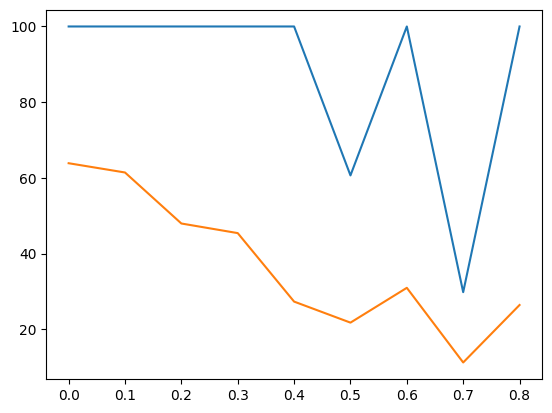

In [17]:
plt.plot(noise_levels, grating_accuracies, label='Gabor Accuracy')
plt.plot(noise_levels, cifar_accuracies, label='CIFAR-10 Accuracy')